# Traffic-Light-Detection-and-Classification

This project is one part of the Udacity Self-Driving Car Capstone Project. Within a simulator, the car will drive around a track and needs to stop at intersections with red traffic lights. Therefore a process is needed to identify traffic lights in image data and classify the light color. The intersections in the simulator are more simplistic than a real world example, since there are only 3 states (Red, Yellow, Green) and no arrows for example. Therefore only one identified color refers to all lanes in the simulator. Nevertheless one focus is also the speed of the model: the whole process should run multiple times per s. 

Project goals:
- use an existing tensorflow object detection model to accuratly identify traffic lights in images
- generate training data with object detecion and BOSCH dataset (can be found here)
- implement and train CNN on created data
- implement full pipeline from image input to classification


In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from benedict import benedict
import pickle
from time import time

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda, Dropout, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

tf.__version__

'1.15.0'

## 1. Object detection for traffic lights

The first objective in this project is to successfully extract traffic light objects from image input to a standardized format. For this task it's best to refer to already trained models. Well suited for this task are the object detection models in the [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). 

These models are pre-trained on the [COCO
dataset](http://mscoco.org), the [Kitti dataset](http://www.cvlibs.net/datasets/kitti/),
the [Open Images dataset](https://github.com/openimages/dataset), the
[AVA v2.1 dataset](https://research.google.com/ava/) and the
[iNaturalist Species Detection Dataset](https://github.com/visipedia/inat_comp/blob/master/2017/README.md#bounding-boxes) and already feature a label for traffic lights (10). Therefore any of these models could be used out of the box. 

Since the target project is within an embedded system, speed will matter. Considering this, I used the ssd_mobilenet_v1_0.75_depth_coco, which on reference has the fastest performance. 

First I initilize the tl_detection with the already existing frozen inference graph and link the input and output tensors of the graph with class variables. The input tensor in this graph is an image of any size. The outputs are then boxes around the object, score (certainty) and the corresponding class. The outputs are ordered by score, which means high certainty is also high up on the list. I implemented a filter on the score to be at least above 0.5 certainty.

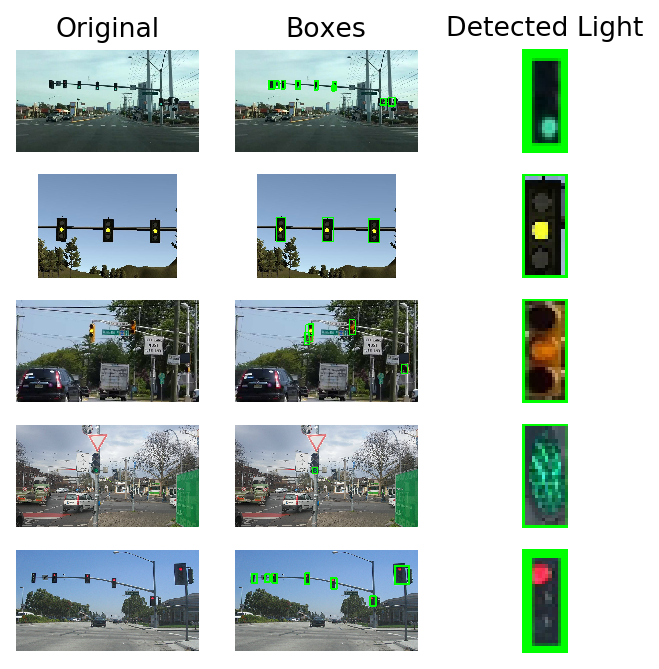

In [2]:
class tl_detection:
    def __init__(self):

        self.path = "ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb"
        self.dg = tf.Graph()
        self.img = None
        self.img_out_c = None
        
        with self.dg.as_default():
            gdef = tf.GraphDef()
            with open(self.path, 'rb') as f:
                gdef.ParseFromString(f.read())
                tf.import_graph_def(gdef, name="")
            self.sess = tf.Session(graph=self.dg)
            self.img_t = self.dg.get_tensor_by_name('image_tensor:0')
            self.box_t = self.dg.get_tensor_by_name('detection_boxes:0')
            self.score_t = self.dg.get_tensor_by_name('detection_scores:0')
            self.class_t = self.dg.get_tensor_by_name('detection_classes:0')
            self.num_t = self.dg.get_tensor_by_name('num_detections:0')

    def localize_obj(self,img):
        
        self.img_out_c = None
        # net was trained in bgr colorspace
        self.img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # shape of (1,?,?,3)
        input_img = np.expand_dims(self.img, axis=0)

        with self.dg.as_default():
            (detection_boxes, detection_scores, detection_classes,num_detections) = self.sess.run(
                [self.box_t, self.score_t, self.class_t, self.num_t],
                feed_dict={self.img_t: input_img})
            
        self.boxes = detection_boxes
        self.scores = detection_scores
        self.classes = detection_classes
        self.obs = num_detections
        self.update_img()
    
    def update_img(self):
        for obs in zip(self.boxes[0], self.classes[0], self.scores[0]):
            # did we observe traffic lights with high certainty?
            if obs[1] == 10 and obs[2] >= .5:
                # get box and img
                box = obs[0]
                x_min = int(box[0] * self.img.shape[0])
                x_max = int(box[2] * self.img.shape[0])
                y_min = int(box[1] * self.img.shape[1])
                y_max = int(box[3] * self.img.shape[1])
                self.img = cv2.rectangle(self.img, (y_min,x_min),(y_max,x_max), (0,255,0), 5)
                self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
                
                if not self.img_out_c:
                    self.img_out = cv2.resize(self.img[x_min:x_max,y_min:y_max,:],(14,32))
                    self.img_out_c = True


test_imgs = [cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB) for img in ['test_imgs/test1.png',
                                         'test_imgs/test2.png',
                                         'test_imgs/test3.png',
                                         'test_imgs/test4.png',
                                         'test_imgs/test5.png'
                                        ]]
fig, ax = plt.subplots(5,3, dpi=160, figsize=(5,5))
tld = tl_detection()
for i in range(5):    
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
    
    if i == 0:
        ax[i][0].set_title('Original')
        ax[i][1].set_title('Boxes')
        ax[i][2].set_title('Detected Light')
    
    ax[i][0].imshow(test_imgs[i])
    tld.localize_obj(test_imgs[i])
    ax[i][1].imshow(tld.img)
    ax[i][2].imshow(tld.img_out)
    
plt.show();

A small showcase on how the object detection works. The Object detection takes the image as input and stores an image with boxes around traffic lights as well as the image with highest certainty cropped. This format (32,14) will also be the format for the CNN later build to classify the light color. Within the udacity simulator all traffic lights have the same color, therefore we could actually stop and break the loop in the embedded system after we have detected one (see image 2 from simulator). The boxes around the image and the original will not be needed in the final implementation.

## 2. Generating Training data

Now after we have a piece of code to return a cropped and standardized box of a traffic light, we can start to implement a classification model. First thing that needs to be done is to look for some training data. I came across the [BOSCH Dataset](https://hci.iwr.uni-heidelberg.de/node/6132), which features around 5000 consecutive images of driving and already labeled and detected traffic light boxes. So to create our training data, we just need to download it and iterate over all the images to see if they have a traffic light with label in them. I also check that the size of the traffic light is big enough (<25 pixel) to ensure it is actually visible. I end up with ~3600 images of traffic lights with my target size.

In [3]:
d = benedict.from_yaml("train.yaml") # contains picture paths, boxes and label
l = []
imgs = []

for s in d['values']:
    if len(s['boxes']) != 0:
        img_path = s['path']
        img_org = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        for box in s['boxes']:
            label = box['label']
            x_min = int(box['x_min'])
            x_max = int(box['x_max'])
            y_min = int(box['y_min'])
            y_max = int(box['y_max'])
            if (y_max - y_min) > 25:
                new_img = img_org[y_min:y_max,x_min:x_max,:]
                if new_img.shape[0] != 0:
                    try:
                        new_img = cv2.resize(new_img,(14,32))
                        imgs.append(new_img)
                        l.append(label)
                    except:
                        pass
                    
len(l)

3625

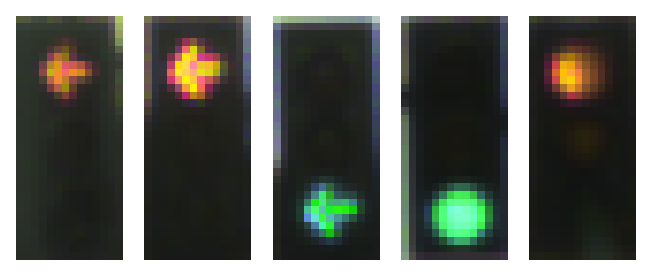

In [4]:
fig, ax = plt.subplots(1,5, dpi=160, figsize=(5,5))
for i in range(5):    
    ax[i].axis('off')
    ax[i].imshow(imgs[i*20])
plt.show();

There are a cupple more things that need to be done before continuing with the model. First is the label: the BOSCH dataset features more labels that we actually need, e.g. the arrows with color which are also distinguished. Since the udacity simulator does not have these features, we can safely drop these in the label as well. Additionally we will have to check the balance of the labels, so we can adjust them if needed. 

In [5]:
l =[i[:1] for i in l]

unique, counts = np.unique(l, return_counts=True)
dict(zip(unique, counts))

{'G': 2041, 'R': 1301, 'Y': 89, 'o': 194}

As can be seen, the dataset is heavily skewed towards Green and Red, which is of course rational when thinking about how traffic lights work - yellow is just a transition phase for a short period of time. The Dataset also features another class 'o', which is basically unknown/turned off. Since this state is also present in udacity simulator, we will keep it. 

Much later in the process I noticed that my model was able to deal much better with the classification when increasing the counts for Yellow & unknown label. Therefore I implemented a random choice skript to generate my training data with weights different than the original distribution. The data used for training features following distributions: {'G': 1149, 'R': 1241, 'Y': 304, 'o': 306}.

In [6]:
d = {key:[] for key in set(l)}
for i in range(0,len(imgs)):
    d[l[i]].append(imgs[i])

random_x = []
random_y = []

for i in range(3000):
    key = np.random.choice(np.array([i for i in d.keys()]), 1, p = [0.1, 0.1, 0.4, 0.4])[0]
    img = np.random.choice(np.array([i for i in range(len(d[key]))]))
    
    random_x.append(d[key][img])
    random_y.append(key)
    
unique, counts = np.unique(random_y, return_counts=True)
dict(zip(unique, counts))

{'G': 1197, 'R': 1211, 'Y': 289, 'o': 303}

In [7]:
match_dict = {
    'G' : 0,
    'R' : 1,
    'Y' : 2,
    'o' : 3
}

random_y = [match_dict[i] for i in random_y]
pickle.dump( [random_x,random_y], open( "data.p", "wb" ) )

Lastly, I change the string class for an integer for the CNN and save everything for the model. My original data can be found in the repo.

## 3. Network Architecture

I choose a similar CNN architecture as NVIDIA on their [End to End Learning for Self-Driving Cars](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) Network and made some adjustments. For once I decreased the size due to a much simpler model. Since we are using (not really much) image data, it is favorable to use tensorflows image data generator to add some random augmentation to our images. This will hopefully improve the models ability to generalize better and deal with some distorted observations that might come from the cars image data.

- Input Layer (32,14,3)
- Normalization Layer (centered around 0)
- Conv2D (16, Kernel = (3,3), Strides = (2,2), Activation = Rectified Linear)
- MaxPooling2D
- Dropoout (0.3)
- Conv2D (32, Kernel = (3,3), Strides = (2,2), Activation = Rectified Linear)
- MaxPooling2D
- Dropoout (0.3)
- Conv2D (64, Kernel = (3,3), Strides = (2,2), Activation = Rectified Linear)
- Dropoout (0.3)
- Dense (100, Activation = Rectified Linear)
- Dropoout (0.3)
- Dense (20, Activation = Rectified Linear)
- Dropoout (0.2)
- Dense (4, Activation = Softmax)

In [8]:
class tl_classifier:
    
    def __init__(self, lr, dc, model=None):
        self.lr = lr
        self.dc = dc
        
        if model == None:
            self.build_model()
        else:
            self.model = load_model(model)
        self.init_generator()
        
    def build_model(self):
        
        self.model = Sequential()
        
        self.model.add(Lambda(lambda x:x / 255.-.5, input_shape=(32, 14, 3)))
        self.model.add(Conv2D(
            filters=16,
            kernel_size=(3,3),
            strides=(2,2),
            padding='same',
            activation='relu'
            ))
        self.model.add(MaxPooling2D(
            pool_size=(2,2)))
        self.model.add(Dropout(0.3)) 
        self.model.add(Conv2D(
            filters=32,
            kernel_size=(3,3),
            strides=(2,2),
            padding='same',
            activation='relu'))
        self.model.add(MaxPooling2D(
            pool_size=(2,2)))
        self.model.add(Dropout(0.3)) 
        self.model.add(Conv2D(
            filters=64,
            kernel_size=(5,5),
            strides=(2,2),
            padding='same',
            activation='relu'))
        self.model.add(Dropout(0.3))   
        self.model.add(Flatten())
        self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(20, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(4,activation='softmax'))        

        self.opt = Adam(lr=self.lr, decay=self.dc)
        self.model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.opt,
                      metrics=['accuracy'])

    def save_model(self):
        self.model.save('model.h5')
    
    def init_generator(self):
        self.IDG = ImageDataGenerator(
                        rotation_range=5,
                        width_shift_range=.05,
                        shear_range=.05,
                        zoom_range=.05,
                        vertical_flip=True,
                        #horizontal_flip = True,
                        validation_split=.9
        )

    def feed_batches(self,x,y,EPOCHS = 20, BATCH_SIZE = 2900):
        
        for EPOCH in range(EPOCHS):
            print('Epoch', EPOCH)
            batches = 0
            for x_batch, y_batch in self.IDG.flow(x, y, batch_size=BATCH_SIZE):
                self.model.fit(x_batch, y_batch, verbose=1)
                batches += 1
                if batches >= len(x) / BATCH_SIZE:
                    break

    def predict(self,x):
        return self.model.predict(x.reshape(1,32,14,3))

## 4. Model Results

The model was trained with a learning rate of 1e-3 and a decay of 1e-5. Since the classification model is quite simple, I noticed that this combination got quite good results. The model is trained for 20 epochs, after which it stagnates and doesnt improve any further.

In [12]:
data = pickle.load( open( "data/data.p", "rb" ) )
import random
random.shuffle(data)

sep = int(len(data[0])*0.8)

x = np.array(data[0][:sep])
y = data[1][:sep]

test_x = np.array(data[0][sep:])
test_y = data[1][sep:]

model = tl_classifier(1e-3, 1e-5)
model.feed_batches(x,y,20)
model.save_model()

Epoch 0
Train on 2400 samples
2400/2400 [==============================] - 1s 232us/sample - loss: 1.2140 - acc: 0.4150
Epoch 1
Train on 2400 samples
2400/2400 [==============================] - 0s 136us/sample - loss: 0.7950 - acc: 0.7121
Epoch 2
Train on 2400 samples
2400/2400 [==============================] - 0s 142us/sample - loss: 0.4783 - acc: 0.8029
Epoch 3
Train on 2400 samples
2400/2400 [==============================] - 0s 146us/sample - loss: 0.3259 - acc: 0.8742
Epoch 4
Train on 2400 samples
2400/2400 [==============================] - 0s 170us/sample - loss: 0.2809 - acc: 0.9121
Epoch 5
Train on 2400 samples
2400/2400 [==============================] - 0s 140us/sample - loss: 0.2250 - acc: 0.9308
Epoch 6
Train on 2400 samples
2400/2400 [==============================] - 0s 148us/sample - loss: 0.2140 - acc: 0.9312
Epoch 7
Train on 2400 samples
2400/2400 [==============================] - 0s 131us/sample - loss: 0.2259 - acc: 0.9304
Epoch 8
Train on 2400 samples
2400/2400 

The classification report with test data show a general accuracy of 0.96. The most trouble for our model is actually the classification of unkown. Since the original distribution of this class is so low, the accuracy in a real world example would probably be better. In general I believe this is a solid model.

In [13]:
check_y = np.array([np.argmax(model.predict(i)) for i in test_x])   
print(classification_report(test_y, check_y, target_names=['G','R','Y','o']))

              precision    recall  f1-score   support

           G       0.99      1.00      0.99       233
           R       0.97      0.94      0.95       243
           Y       0.98      0.84      0.91        63
           o       0.76      0.93      0.84        61

    accuracy                           0.95       600
   macro avg       0.92      0.93      0.92       600
weighted avg       0.96      0.95      0.95       600



## 5. Detection & Classification Pipeline

Now I have to bring all individual pieces together and want to implement them within one class. This class will be feed raw image data, it will store augmented images and return the final prediction of the label. 

For building this we need:
- both of the saved models to be initialized at start
- pipeline for image feed (detection & classification)
- map prediction back to label

In [14]:
class tl_processing:
    def __init__(self):
        self.init_graph()
        self.init_classifier()
        self.state = None
        self.match_dict = {0: 'G',1: 'R',2: 'Y',3: 'o'}
        
    def feed_img(self,img):
        
        self.localize_obj(img)
        self.classify_img()
        
    def get_state(self):
        return self.match_dict[self.state]
        
    def init_graph(self):
        self.path = "models/frozen_inference_graph.pb"
        self.dg = tf.Graph()
        with self.dg.as_default():
            gdef = tf.GraphDef()
            with open(self.path, 'rb') as f:
                gdef.ParseFromString(f.read())
                tf.import_graph_def(gdef, name="")
            self.sess = tf.Session(graph=self.dg)
            self.img_t = self.dg.get_tensor_by_name('image_tensor:0')
            self.box_t = self.dg.get_tensor_by_name('detection_boxes:0')
            self.score_t = self.dg.get_tensor_by_name('detection_scores:0')
            self.class_t = self.dg.get_tensor_by_name('detection_classes:0')
            self.num_t = self.dg.get_tensor_by_name('num_detections:0')
    
    def init_classifier(self):
        self.classifier = load_model('models/model.h5')
        
    def localize_obj(self,img):
        
        self.img_out_c = None
        # net was trained in bgr colorspace
        self.img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # shape of (1,?,?,3)
        input_img = np.expand_dims(self.img, axis=0)

        with self.dg.as_default():
            (detection_boxes, detection_scores, detection_classes,num_detections) = self.sess.run(
                [self.box_t, self.score_t, self.class_t, self.num_t],
                feed_dict={self.img_t: input_img})
            
        self.boxes = detection_boxes
        self.scores = detection_scores
        self.classes = detection_classes
        self.obs = num_detections
        self.update_img()
    
    def update_img(self):
        for obs in zip(self.boxes[0], self.classes[0], self.scores[0]):
            # did we observe traffic lights with high certainty?
            if obs[1] == 10 and obs[2] >= .5:
                # get box and img
                box = obs[0]
                x_min = int(box[0] * self.img.shape[0])
                x_max = int(box[2] * self.img.shape[0])
                y_min = int(box[1] * self.img.shape[1])
                y_max = int(box[3] * self.img.shape[1])
                self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
                
                if not self.img_out_c:
                    self.img_out = cv2.resize(self.img[x_min:x_max,y_min:y_max,:],(14,32))
                    self.img_out_c = True
                    break
                    
    def classify_img(self):
        self.state = np.argmax(self.classifier.predict(self.img_out.reshape(1,32,14,3)))

tl = tl_processing()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Classification: G after 2.885s
Classification: Y after 0.058s
Classification: Y after 0.06s
Classification: G after 0.072s
Classification: R after 0.06s


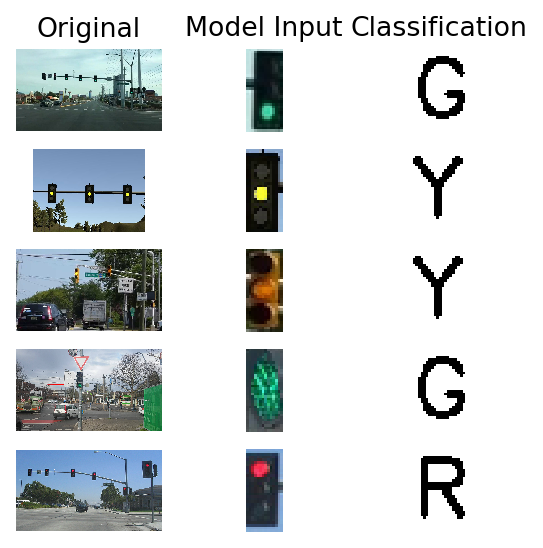

In [15]:
fig, ax = plt.subplots(5,3, dpi=160, figsize=(4,4))

for i in range(5):    
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
    
    if i == 0:
        ax[i][0].set_title('Original')
        ax[i][1].set_title('Model Input')
        ax[i][2].set_title('Classification')
    
    ax[i][0].imshow(test_imgs[i])
    start = time()
    tl.feed_img(test_imgs[i])
    print(f'Classification: {tl.get_state()} after {round(time() - start,3)}s')
    
    ax[i][1].imshow(tl.img_out)
    
    label_img = np.zeros((32,32,3))
    label_img.fill(1)
    label_img = cv2.putText(label_img, tl.get_state(), (6,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2) 
                   
    ax[i][2].imshow(label_img)
    
plt.show();

As can be seen the first prediction takes some time to complete. The image from the simulator (2nd) is then afterwards completed after 0.06s. Therefore it could be run multiple times per second within the simulator to classify the state. One might also think of adding some additional logic to the classifications. 

For example the order of traffic light colors is always G -> Y -> R -> Y -> G. So when we successfully identified the inital image we can compare this information with the following observations to exclude some unlogical classifications or will already know something about the future if a light turns yellow. For example we could calculate the distance to the traffic light, to see if we will still make it in time or if we should treat that as a red light and stop. Similary, when the traffic light turns yellow from red, we know its already safe to accelerate. 